# 多重共线性

## 1. 创建测试数据集

In [1]:
import pandas as pd
import numpy as np

np.random.seed(42)
n = 100

# 1. 连续变量 vs 连续变量
cont1 = np.random.normal(0, 1, n)
cont2 = cont1 * 0.8 + np.random.normal(0, 0.5, n)

# 2. 二分类 vs 连续变量
binary = np.random.randint(0, 2, n)
cont_binary = binary * 3 + np.random.normal(0, 1, n)

# 3. 有序分类 vs 有序分类 
ordinal = np.random.choice([1,2,3,4,5], n, p=[0.1,0.2,0.4,0.2,0.1])
ordinal2 = np.random.choice([1,2,3,4], n, p=[0.2,0.3,0.3,0.2])

# 创建DataFrame
df = pd.DataFrame({
    '连续1': cont1,
    '连续2': cont2,
    '二分类': binary,
    '连续_二分类': cont_binary,
    '有序分类': ordinal,
    '有序分类2': ordinal2
})

df.head()


,连续1,连续2,二分类,连续_二分类,有序分类,有序分类2
0,0.496714,-0.310314,1,3.504987,1,3
1,-0.138264,-0.320934,1,3.865755,4,4
2,0.647689,0.346794,0,-1.200296,1,4
3,1.523030,0.817285,1,2.665499,4,2
4,-0.234153,-0.267966,0,-0.474945,4,2


## 2 多重共线性识别方法

### 2.1 计算相关系数矩阵（自动计算，调用包）

In [2]:
print("=== 自动相关系数矩阵 ===")
corr_matrix = df.corr()
corr_matrix

=== 自动相关系数矩阵 ===


,连续1,连续2,二分类,连续_二分类,有序分类,有序分类2
连续1,1.000000,0.813799,-0.027130,-0.062486,-0.135545,0.035161
连续2,0.813799,1.000000,-0.079595,-0.146395,-0.085873,0.025366
二分类,-0.027130,-0.079595,1.000000,0.849112,-0.019708,-0.018930
连续_二分类,-0.062486,-0.146395,0.849112,1.000000,0.014760,-0.018496
有序分类,-0.135545,-0.085873,-0.019708,0.014760,1.000000,-0.025210
有序分类2,0.035161,0.025366,-0.018930,-0.018496,-0.025210,1.000000


### 2.2 手动验证 相关系数矩阵（根据不同分类来计算）

In [3]:
from scipy import stats

# 手动计算验证
print("\n=== 手动验证 ===")
# 1. 连续 vs 连续 (皮尔逊)
pearson = stats.pearsonr(df['连续1'], df['连续2'])[0]
print(f"连续1 vs 连续2 (皮尔逊): {pearson:.6f}")

# 2. 二分类 vs 连续 (点二列)
pb = stats.pointbiserialr(df['二分类'], df['连续_二分类'])[0]
print(f"二分类 vs 连续_二分类 (点二列): {pb:.6f}")

# 3. 有序 vs 有序 (斯皮尔曼)
spearman = stats.spearmanr(df['有序分类'], df['有序分类2'])[0]
print(f"有序分类 vs 有序分类2 (斯皮尔曼): {spearman:.6f} ")

# 5. 有序 vs 有序 (肯德尔)
kendall = stats.kendalltau(df['有序分类'], df['有序分类2'])[0]
print(f"有序分类 vs 有序分类2 (肯德尔): {kendall:.6f}")



=== 手动验证 ===
连续1 vs 连续2 (皮尔逊): 0.813799
二分类 vs 连续_二分类 (点二列): 0.849112
有序分类 vs 有序分类2 (斯皮尔曼): -0.021287 
有序分类 vs 有序分类2 (肯德尔): -0.017050


### 2.3 手动验证 相关系数矩阵（所有变量类型都采用皮尔逊相关系数）

In [4]:
# 手动计算验证
print("\n=== 手动验证 ===")
# 1. 连续 vs 连续 (皮尔逊)
pearson = stats.pearsonr(df['连续1'], df['连续2'])[0]
print(f"连续1 vs 连续2 (皮尔逊): {pearson:.6f}")

# 2. 二分类 vs 连续 (点二列)
pb = stats.pearsonr(df['二分类'], df['连续_二分类'])[0]
print(f"二分类 vs 连续_二分类 (皮尔逊): {pb:.6f}")

# 3. 有序 vs 有序 (斯皮尔曼)
spearman = stats.pearsonr(df['有序分类'], df['有序分类2'])[0]
print(f"有序分类 vs 有序分类2 (皮尔逊): {spearman:.6f} ")

# 5. 有序 vs 有序 (肯德尔)
kendall = stats.pearsonr(df['有序分类'], df['有序分类2'])[0]
print(f"有序分类 vs 有序分类2 (皮尔逊): {kendall:.6f}")


=== 手动验证 ===
连续1 vs 连续2 (皮尔逊): 0.813799
二分类 vs 连续_二分类 (皮尔逊): 0.849112
有序分类 vs 有序分类2 (皮尔逊): -0.025210 
有序分类 vs 有序分类2 (皮尔逊): -0.025210


### 2.3 辅助回归与方差膨胀因子（手动计算）
#### 方差膨胀因子(VIF)计算公式： $VIF_j = \frac{1}{1 - R^2_j}$

其中：
- $VIF_j$ 是第j个自变量的方差膨胀因子
- $R^2_j$ 是以第j个自变量为因变量，其他所有自变量为自变量的回归模型的决定系数

#### VIF值的含义
- VIF = 1: 表示没有多重共线性
- 1 < VIF < 5: 表示中等程度的多重共线性
- 5 < VIF < 10: 表示较强的多重共线性
- VIF > 10: 表示严重的多重共线性，需要处理

In [5]:
import statsmodels.api as sm
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 准备数据
variables = ['连续1', '连续2', '二分类', '连续_二分类', '有序分类', '有序分类2']
# 辅助回归分析
print("\n=== 辅助回归分析 ===")
for i, target in enumerate(variables, 1): # 对 variables 列表进行枚举，且从1开始
    print(f"辅助回归{i} ({target}:作为因变量):")
    y = df[target]     # 准备因变量
    x_vars = [var for var in variables if var != target]  # 准备自变量（排除当前因变量）
    X = df[x_vars].values
    cons = np.ones(len(X)) # 添加常数项
    X = np.c_[cons, X]
    model = sm.OLS(y, X) # 拟合模型
    results = model.fit()
    # 输出结果
    print(f"R-squared: {results.rsquared:.6f}；VIF: {1/(1-results.rsquared):.6f}")

# 计算所有变量的VIF
X = df[variables].values
cons = np.ones(len(X))
X = np.c_[cons, X]

vif_data = pd.DataFrame()
vif_data["variable"] = ['常数项','连续1', '连续2', '二分类', '连续_二分类', '有序分类', '有序分类2']
vif_values = []
for i in range(X.shape[1]):
    vif = variance_inflation_factor(X, i)
    vif_values.append(vif)
vif_data["VIF"] = vif_values

print("\n=== 所有变量的VIF值 ===")
vif_data


=== 辅助回归分析 ===
辅助回归1 (连续1:作为因变量):
R-squared: 0.670680；VIF: 3.036559
辅助回归2 (连续2:作为因变量):
R-squared: 0.674249；VIF: 3.069833
辅助回归3 (二分类:作为因变量):
R-squared: 0.724358；VIF: 3.627890
辅助回归4 (连续_二分类:作为因变量):
R-squared: 0.729970；VIF: 3.703295
辅助回归5 (有序分类:作为因变量):
R-squared: 0.024110；VIF: 1.024706
辅助回归6 (有序分类2:作为因变量):
R-squared: 0.002050；VIF: 1.002055

=== 所有变量的VIF值 ===


,variable,VIF
0,常数项,14.329891
1,连续1,3.036559
2,连续2,3.069833
3,二分类,3.627890
4,连续_二分类,3.703295
5,有序分类,1.024706
6,有序分类2,1.002055


## 3 多重共线性解决办法

### 3.1 岭回归（手动计算）

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

# 准备数据
X = df[['连续1', '连续2', '二分类', '有序分类', '有序分类2']].values
y = df['连续_二分类'].values

# 标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 1. 手动实现岭回归
def ridge_manual(X, y, alpha):
    X = np.c_[np.ones(len(X)), X]
    n_features = X.shape[1]
    I = np.eye(n_features)
    I[0,0] = 0  # 不惩罚常数项
    beta = np.linalg.inv(X.T @ X + alpha * I) @ X.T @ y
    return beta

# 2. 使用不同alpha值计算
alphas = [0.001, 0.1, 1.0, 10.0, 100.0]
manual_coefs = []
sklearn_coefs = []

for alpha in alphas:
    # 手动实现
    beta_manual = ridge_manual(X_scaled, y, alpha)
    manual_coefs.append(beta_manual[1:])  # 不包括截距
    
    # sklearn实现
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_scaled, y)
    sklearn_coefs.append(ridge.coef_)

# 3. 输出alpha=1.0时的比较结果
print("\n=== Alpha=1.0 时的系数比较 ===")
manual_idx = alphas.index(1.0)  # 找出alpha=1.0在alphas列表中的索引位置
print("\n手动实现的系数:")
for name, coef in zip(df.columns[:-1], manual_coefs[manual_idx]):  # 遍历特征名和对应系数
    print(f"{name}: {coef:.4f}")  # 打印每个特征的系数，保留4位小数

print("\nsklearn实现的系数:")
ridge = Ridge(alpha=1.0).fit(X_scaled, y)  # 使用sklearn重新拟合alpha=1.0的模型
for name, coef in zip(df.columns[:-1], ridge.coef_):  # 遍历特征名和对应系数
    print(f"{name}: {coef:.4f}")  # 打印每个特征的系数，保留4位小数

# 4. 输出alpha=100.0时的比较结果
print("\n=== Alpha=100.0 时的系数比较 ===")
manual_idx = alphas.index(100.0)  # 找出alpha=100.0在alphas列表中的索引位置
print("\n手动实现的系数:")
for name, coef in zip(df.columns[:-1], manual_coefs[manual_idx]):  # 遍历特征名和对应系数
    print(f"{name}: {coef:.4f}")  # 打印每个特征的系数，保留4位小数

print("\nsklearn实现的系数:")
ridge = Ridge(alpha=100.0).fit(X_scaled, y)  # 使用sklearn重新拟合alpha=100.0的模型
for name, coef in zip(df.columns[:-1], ridge.coef_):  # 遍历特征名和对应系数
    print(f"{name}: {coef:.4f}")  # 打印每个特征的系数，保留4位小数


=== Alpha=1.0 时的系数比较 ===

手动实现的系数:
连续1: 0.1331
连续2: -0.2433
二分类: 1.4745
连续_二分类: 0.0518
有序分类: -0.0020

sklearn实现的系数:
连续1: 0.1331
连续2: -0.2433
二分类: 1.4745
连续_二分类: 0.0518
有序分类: -0.0020

=== Alpha=100.0 时的系数比较 ===

手动实现的系数:
连续1: -0.0044
连续2: -0.0973
二分类: 0.7481
连续_二分类: 0.0159
有序分类: -0.0078

sklearn实现的系数:
连续1: -0.0044
连续2: -0.0973
二分类: 0.7481
连续_二分类: 0.0159
有序分类: -0.0078


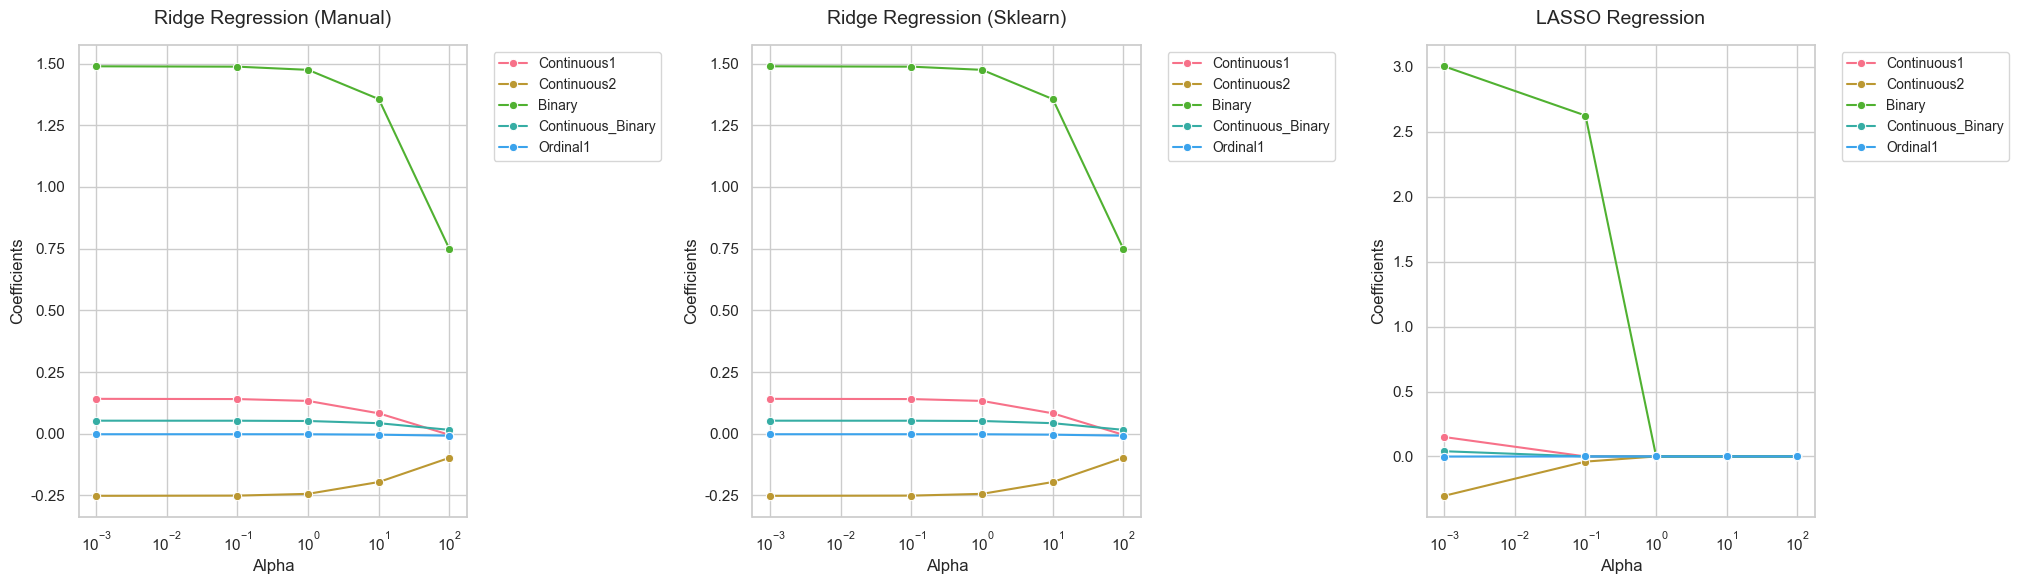

In [7]:
import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt  # 确保导入plt
import numpy as np
from sklearn.linear_model import Lasso # pip install scikit-learn

# 设置中英文字体
# 修改字体设置，优先使用支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial']  # 将中文字体放在前面
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
sns.set_theme(style="whitegrid")
sns.set_palette("husl")

# 创建图形并调整子图之间的间距
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))
plt.subplots_adjust(right=0.85, wspace=0.3)  # 为图例留出空间并增加子图间距

# 创建英文标签映射字典
english_labels = {
    '连续1': 'Continuous1',
    '连续2': 'Continuous2',
    '二分类': 'Binary',
    '连续_二分类': 'Continuous_Binary',
    '有序分类': 'Ordinal1',
    '有序分类2': 'Ordinal2'
}

# 手动实现岭回归结果图
for i in range(X.shape[1]):
    col_name = df.columns[i]
    label = english_labels.get(col_name, col_name)  # 使用映射或保持原样
    sns.lineplot(x=alphas, y=[coef[i] for coef in manual_coefs], 
                marker='o', label=label, ax=ax1)
ax1.set_xscale('log')
ax1.set_xlabel('Alpha', fontsize=12)
ax1.set_ylabel('Coefficients', fontsize=12)
ax1.set_title('Ridge Regression (Manual)', fontsize=14, pad=15)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# sklearn实现岭回归结果图
for i in range(X.shape[1]):
    col_name = df.columns[i]
    label = english_labels.get(col_name, col_name)  # 使用映射或保持原样
    sns.lineplot(x=alphas, y=[coef[i] for coef in sklearn_coefs], 
                marker='o', label=label, ax=ax2)
ax2.set_xscale('log')
ax2.set_xlabel('Alpha', fontsize=12)
ax2.set_ylabel('Coefficients', fontsize=12)
ax2.set_title('Ridge Regression (Sklearn)', fontsize=14, pad=15)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# 添加LASSO回归结果
lasso_coefs = []
for alpha in alphas:
    lasso = Lasso(alpha=alpha, fit_intercept=True, max_iter=10000)
    # 使用X和y替代X_train和y_train
    lasso.fit(X, y)
    lasso_coefs.append(lasso.coef_)

# 绘制LASSO回归结果图
for i in range(X.shape[1]):
    col_name = df.columns[i]
    label = english_labels.get(col_name, col_name)  # 使用映射或保持原样
    sns.lineplot(x=alphas, y=[coef[i] for coef in lasso_coefs], 
                marker='o', label=label, ax=ax3)
ax3.set_xscale('log')
ax3.set_xlabel('Alpha', fontsize=12)
ax3.set_ylabel('Coefficients', fontsize=12)
ax3.set_title('LASSO Regression', fontsize=14, pad=15)
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# 调整整体布局
plt.tight_layout(rect=[0, 0, 0.85, 1])  # 调整整体布局，保留图例空间
plt.show()